# Image Classification

In this  you will be building a script to classify images of animals. The assignment is broken up into sections and you need to complete each section successively. The sections are:

1. Data Processing
2. Model Definition
3. Model Training
4. Model Evaluation

In addition to this coding exercise, you will also need to write a 1-2 page report analysing and critically evaluating you models results.

In [ ]:
# Enter your module imports here, some modules are already provided

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing



In [ ]:
# CodeGrade Tag DataProc

label_dict = {'cat' : 0,
              'dog' : 1,
              'wild' : 2}

# This function is provided to read in the image files from the folder on your
# Google Drive
def parse_image(filename):
  parts = tf.strings.split(filename, os.sep)
  label = parts[-2]
  label = tf.strings.to_number(label)

  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

img_loc = "/content/drive/MyDrive/Animals/"

train_list_ds = tf.data.Dataset.list_files(img_loc + "train/*/*")
valid_list_ds = tf.data.Dataset.list_files(img_loc + "val/*/*")


**Create a function called "img_process" converts the images to float32 datatype and resizes them to 64x64 pixels.**

In [ ]:

### Write a function called img_process, which takes in the image and label as
### inputs, converts the data type of the image to tf.float32, resizes the
### image to (64,64), and finally returns the image and labels.

def img_process(image, label):
    # Convert image data type to tf.float32
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    # Resize image to (64, 64)
    image = tf.image.resize(image, [64, 64])
    print("Processed Image Shape:", image.shape)
    print("Label:", label)
    return image, label
print(img_process)


<function img_process at 0x7d56872c13f0>


**Using the tf.data API, load in the training and validation data. Be mindful of efficient data processing good practice to minimise the time it takes to load the data.**

In [ ]:

### Use the parse_image and img_process functions to construct the training and
### validation datasets. You should utilise good practice in optimising the
### dataset loading. Use a batch size of 128. Use techniques like caching and
### prefetching to efficiently load the data.

# Data Processing with tf.data API
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 128

# Load and preprocess training data
train_ds = (
    tf.data.Dataset.list_files(img_loc + "train/*/*")
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(img_process, num_parallel_calls=AUTOTUNE)
    .shuffle(buffer_size=1000)
    .batch(batch_size)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)

# Load and preprocess validation data
valid_ds = (
    tf.data.Dataset.list_files(img_loc + "val/*/*")
    .map(parse_image, num_parallel_calls=AUTOTUNE)
    .map(img_process, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(buffer_size=AUTOTUNE)
)



Processed Image Shape: (64, 64, None)
Label: Tensor("args_1:0", shape=(), dtype=float32)
Processed Image Shape: (64, 64, None)
Label: Tensor("args_1:0", shape=(), dtype=float32)


# Model Definition

**Using the Keras Functional API, create a convolutional neural network with the architecture show in the model summary below.**

**A few important points to consider:**

* Call the convolutional layers and the first dense layer should have ReLU activation functions. The output layer should have a SoftMax activation function.
* Pay attention to the output shapes and the number of partmeters for each layer, as these give indications as to the correct settings for the number of filters, kernel size, stride length and padding.
* Use the layer names provided in the summary in your model.

In [ ]:

### Define the model using the Keras Functional API. Use the summary above as a
### guide for the model parameters. You will need to define the filters/units of
### the layers correctly, as well as the kernel size, stride length and padding
### of the convolutional layers.
# Define the input layer
input_layer = Input(shape=(64, 64, 3), name='Input')

# Convolutional layers
conv0 = Conv2D(16, kernel_size=(5, 5), strides=(2, 2), padding='same', activation='relu', name='Conv0')(input_layer)
conv1 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='Conv1')(conv0)
conv2 = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='Conv2')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='Pool1')(conv2)

conv3 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='Conv3')(pool1)
conv4 = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='Conv4')(conv3)
pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='Pool2')(conv4)

conv5 = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='Conv5')(pool2)
conv6 = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', name='Conv6')(conv5)

# Global Average Pooling layer
global_pool = GlobalAveragePooling2D(name='GlobalPool')(conv6)

# Fully Connected layers
fc1 = Dense(512, activation='relu', name='FC1')(global_pool)

# Output layer
output_layer = Dense(10, activation='softmax', name='Output')(fc1)# when total classes are 3 why are we making ten classes ?

# Create the model
model = keras.Model(inputs=input_layer, outputs=output_layer)



In [ ]:

### Print the model summary and confirm is has the same architecture as the one
### provided.
# Display the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        1216      
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0         
                                                                 
 Conv3 (Conv2D)              (None, 16, 16, 64)        18496     
                                                                 
 Conv4 (Conv2D)              (None, 16, 16, 64)        36928 

**Compile the model using the Adam Optimizer with a learning rate of ```5e-5```, ```sparse categorical crossentropy``` loss function, and ```accuracy``` metric.**

In [ ]:

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])



# Model Training

**Create a Model Checkpoint Callback that saves the weights of the best performing epoch, based on the validation accuracy.**

In [ ]:

### Create a ModelCheckpoint callback to store the bext weights from the model,
### based on the validation accuracy. Call this callback "checkpoint_callback"



# Define the checkpoint callback
checkpoint_filepath = '/content/checkpoint'
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath,
                                      save_weights_only=True,
                                      monitor='val_accuracy',
                                      mode='max',
                                      save_best_only=True,
                                      verbose=1)




**Create a Learning Rate Scheduler Callback that utilises the provided function to decrease the learning rate during training.**

In [ ]:

### Using the function provided, create a LearningRateScheduler callback, call
### it "lr_callback"

from tensorflow.keras.callbacks import LearningRateScheduler

# Define the learning rate scheduler callback
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

lr_callback = LearningRateScheduler(scheduler)





**Train the model for 100 epochs, using the callbacks you made previously. Store the losses and metrics to use later.**

In [ ]:

### Train the model for 100 epochs, using the callbacks you have created. Store
### the losses and metrics in a history object.

# Model Training with ModelCheckpoint and LearningRateScheduler callbacks
num_epochs = 100
history = model.fit(train_ds, epochs=num_epochs, validation_data=valid_ds, callbacks=[checkpoint_callback, lr_callback])

# Access losses and metrics from the history object
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']


Epoch 1/100
115/115 [==============================] - ETA: 0s - loss: 1.5037 - accuracy: 0.3283 
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /content/checkpoint
115/115 [==============================] - 1491s 12s/step - loss: 1.5037 - accuracy: 0.3283 - val_loss: 1.1009 - val_accuracy: 0.3333 - lr: 5.0000e-05
Epoch 2/100
114/115 [============================>.] - ETA: 0s - loss: 1.0995 - accuracy: 0.3558
Epoch 2: val_accuracy did not improve from 0.33333
115/115 [==============================] - 2s 17ms/step - loss: 1.0995 - accuracy: 0.3558 - val_loss: 1.0952 - val_accuracy: 0.3333 - lr: 5.0000e-05
Epoch 3/100
113/115 [============================>.] - ETA: 0s - loss: 1.0719 - accuracy: 0.3983
Epoch 3: val_accuracy improved from 0.33333 to 0.52533, saving model to /content/checkpoint
115/115 [==============================] - 2s 16ms/step - loss: 1.0711 - accuracy: 0.4000 - val_loss: 1.0098 - val_accuracy: 0.5253 - lr: 5.0000e-05
Epoch 4/100
113/115 [======

# Model Evaluation

**Create plots using the losses and metrics. In your report, discuss these results and critically evaluate the models performance.**

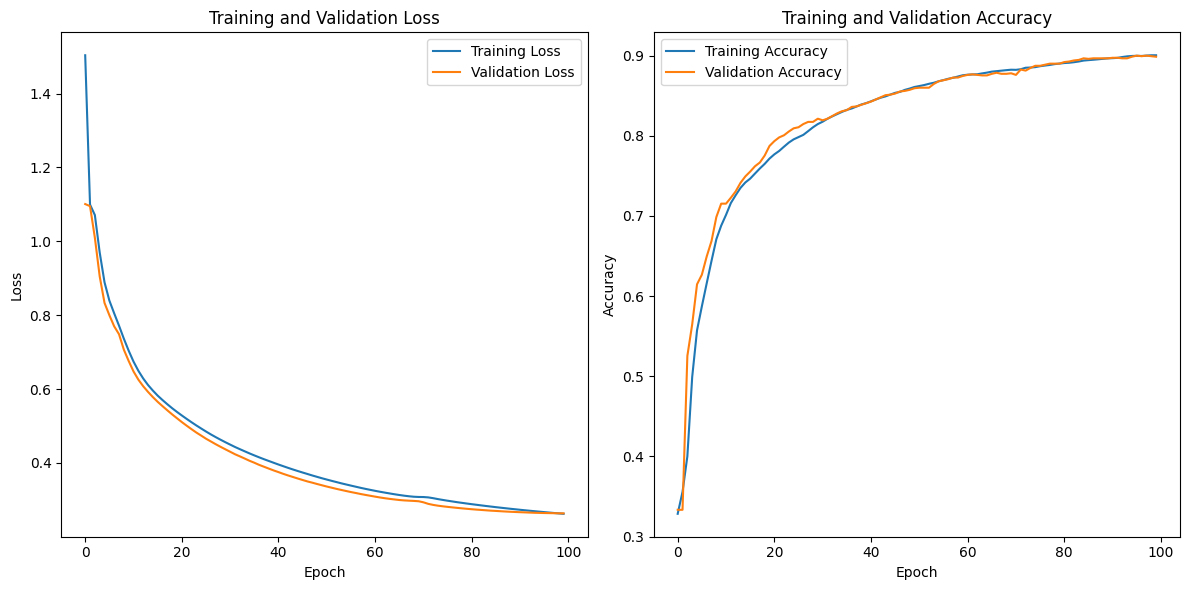

In [ ]:


# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


**Load the best weights from your model checkpoint, and create plots demonstrating the classification perfomnce for all three classes. Include these plots in your report, and critically evaluate on the performance of the model across the classes.**

3/3 [==============================] - 0s 137ms/step


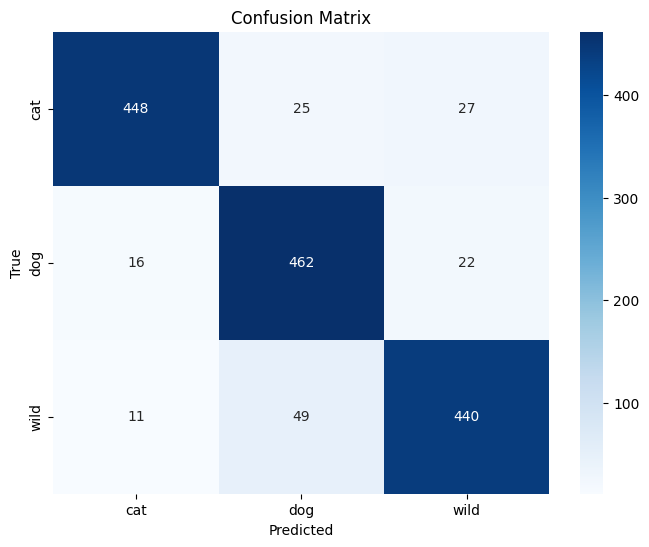

              precision    recall  f1-score   support

         cat       0.94      0.90      0.92       500
         dog       0.86      0.92      0.89       500
        wild       0.90      0.88      0.89       500

    accuracy                           0.90      1500
   macro avg       0.90      0.90      0.90      1500
weighted avg       0.90      0.90      0.90      1500



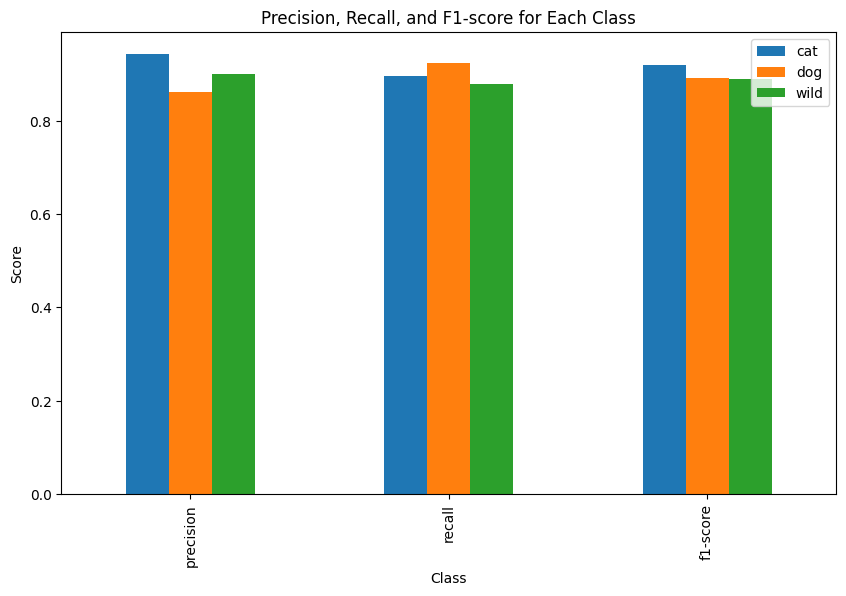

In [ ]:

# Load the best weights from the model checkpoint
model.load_weights(checkpoint_filepath)

# Create a function to make predictions on a set of images
def predict_images(model, image_dataset):
    predictions = []
    true_labels = []

    for image, label in image_dataset:
        true_labels.extend(label.numpy())
        predictions.extend(tf.argmax(model.predict(image), axis=1).numpy())

    return true_labels, predictions

# Use the function to get predictions for validation data
true_labels, predictions = predict_images(model, valid_ds)

# Define class labels
class_labels = ['cat', 'dog', 'wild']

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create classification report
report = classification_report(true_labels, predictions, target_names=class_labels)

# Print and display classification report
print(report)

# Plot bar chart for precision, recall, and F1-score
precision_recall_f1 = pd.DataFrame.from_dict(classification_report(true_labels, predictions, target_names=class_labels, output_dict=True)).iloc[:-1, :3]
precision_recall_f1.plot(kind='bar', figsize=(10, 6))
plt.title('Precision, Recall, and F1-score for Each Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.show()
